# Branch Algo Updates Demo

To set this up, set the `TSKIT_REPO` variable to point to where you want the repo cloned. From there, everything should "just work"

In [1]:
from pathlib import Path

TSKIT_REPO = Path("~/test_ts").expanduser()

This step will leave you with a repo that's editable so you can edit and restart the NB for tinkering

In [2]:
%%bash -s "$TSKIT_REPO"
REPO_PATH="$1"
[ -d "$REPO_PATH" ] && echo "$REPO_PATH already set up" && exit 0
git clone -b branch-stat-algo-rewrite git@github.com:lkirk/tskit.git "$REPO_PATH"
python -m venv "$REPO_PATH/python/ve"
source "$REPO_PATH/python/ve/bin/activate"
pip install -r "$REPO_PATH/python/requirements/development.txt"
(cd "$REPO_PATH/python" && make)
pip install -e "$REPO_PATH/python"

/home/lkirk/test_ts already set up


In [3]:
import sys

PY_VERSION = f"{sys.version_info.major}.{sys.version_info.minor}"
TSKIT_VE = str(TSKIT_REPO / f"python/ve/lib/python{PY_VERSION}/site-packages")
TSKIT_PY = str(TSKIT_REPO / "python")

for p in [TSKIT_VE, TSKIT_PY]:
    if not sys.path[0] == p:
        sys.path.insert(0, p)

import io

import msprime
import numpy as np
import tskit
from tests.test_ld_matrix import ld_matrix

# Tests

Both of these cases hit NaNs in the ratio stats (notably $r^2$)

## Simple
This is our simple, hand-drawn example

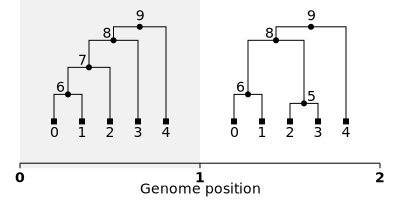

In [4]:
ts = tskit.load_text(
    nodes=io.StringIO(
        """\
is_sample time
1         0
1         0
1         0
1         0
1         0
0         4
0         6
0         12
0         18
0         21
"""
    ),
    edges=io.StringIO(
        """\
left right parent child
0    2     6      0,1
0    1     7      2,6
0    1     8      3,7
0    2     9      4,8
1    2     5      2,3
1    2     8      5,6
"""
    ),
    strict=False,
)

ts.draw_svg()

### $\pi_2$

In [5]:
c = ts.ld_matrix(stat="pi2", mode="branch")

In [6]:
py = ld_matrix(ts, stat="pi2", mode="branch")

In [7]:
py

array([[180.6336, 178.4832],
       [178.4832, 176.3584]])

In [8]:
c

array([[180.6336, 178.4832],
       [178.4832, 176.3584]])

In [9]:
np.isclose(c, py).all(), (c - py).max(), (c - py).min()

(True, 8.526512829121202e-14, -1.7053025658242404e-13)

### $r^2$

In [10]:
c = ts.ld_matrix(mode="branch", stat="r2")

In [11]:
py = ld_matrix(ts, mode="branch", stat="r2")

In [12]:
nanmask = ~np.isnan(c)
np.isclose(c[nanmask], py[nanmask]).all(), (c[nanmask] - py[nanmask]).max(), (c[nanmask] - py[nanmask]).min()

(True, 2.2737367544323206e-13, 0.0)

In [13]:
c

array([[1821.5       ,           nan],
       [1586.66666667,           nan]])

In [14]:
py

array([[1821.5       , 1586.66666667],
       [1586.66666667, 1735.83333333]])

## More Complex
Here's an example of a more complex example.

In [15]:
ts = msprime.sim_ancestry(
    samples=10,
    ploidy=1,
    sequence_length=40,
    recombination_rate=1e-4,
    population_size=1e3,
    random_seed=23,
)

### $\pi_2$

In [16]:
c = ts.ld_matrix(mode="branch", stat="pi2")

In [17]:
py = ld_matrix(ts, mode="branch", stat="pi2")

In [18]:
np.isclose(c, py).all(), (c - py).max(), (c - py).min()

(True, 1.5832483768463135e-08, -7.450580596923828e-09)

### $r^2$

In [19]:
c = ts.ld_matrix(mode="branch", stat="r2")

In [20]:
py = ld_matrix(ts, mode="branch", stat="r2")

In [21]:
nanmask = ~np.isnan(c)
np.isclose(c[nanmask], py[nanmask]).all(), (c[nanmask] - py[nanmask]).max(), (c[nanmask] - py[nanmask]).min()

(True, 7.450580596923828e-08, -8.940696716308594e-08)

In [22]:
c[0]

array([39502862.98000915, 52395794.02243844, 70767284.87660967,
       70786992.33035223, 69643724.95931736, 30483545.5009362 ,
       25673689.33023222, 19698955.5183011 , 15025683.44730757,
       19698955.5183011 ,  6194092.26610015,  5437926.70221875,
                     nan,               nan,               nan,
                     nan])

In [23]:
py[0]

array([39502862.98000916, 52395794.02243846, 70767284.87660968,
       70786992.33035226, 69643724.95931739, 30483545.50093625,
       25673689.33023227, 19698955.51830116, 15025683.44730762,
       19698955.51830115,  6194092.26610019,  5437926.7022188 ,
        4824109.1753188 ,  5375057.16385493,  4304693.88301278,
        4568993.24569805])